<a href="https://colab.research.google.com/github/CheayeonLee/ESAA_OB/blob/main/1%EC%A3%BC%EC%B0%A8%EA%B3%BC%EC%A0%9C(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 3. 분류

## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

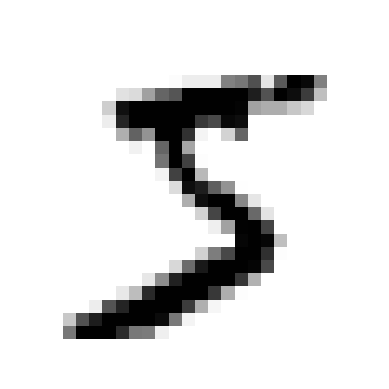

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
# 레이블은 문자열이므로 y를 정수로 변환
import numpy as np
y = y.astype(np.int8) # unit8을 했을 땐 오류발생

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

* 5-감지기는 '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 '이진 분류기'

In [7]:
# 분류작업을 위해 타깃 벡터를 생성
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

#### 확률적 경사 하강법(SGD)
- 매우 큰 데이터셋을 효율적으로 처리하는 장점
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문(온라인 학습에 유리)
- sgd classifier는 훈련하는 데 무작위성을 사용해 이름에 '확률적'이 붙어있음

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

True: 이미지가 5를 나타낸다고 추측한 것

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

#### StratifidKFold
- 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측
- 올바른 예측의 수를 세어 정확한 예측의 비율을 출력

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# 모든 이미지를 '5 아님' 클래스로 분류
from sklearn.base import BaseEstimator

class Neve5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Neve5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%가 나온 것

=정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유(특히 불균형한 데이터셋)

### 3.3.2 오차 행렬

In [14]:
from sklearn.model_selection import cross_val_predict
# 테스트 세트로 예측을 만들 수 있지만 이는 분류기가 출시 준비를 마치고 나서 프로젝트의 '맨 마지막'에 사용하는 것!
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- 오차행렬의 행: True
- 오차행렬의 열: Predict

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도 = TP / (TP+FP)
(오차 행렬보다 더 요약된 지표가 필요한 경우)
- 재현율 = TP / (TP+FN)(분류기가 정확하게 감지한 양성 샘플의 비율)
(=민감도 or 진짜 양성 비율)

### 3.3.2 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score
# 5로 판별된 이미지 중 83%만 정확
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
# 전체 숫자 5에서 65%만 감지
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- F1 score: TP/(TP+((FN+FP)/2))
(정밀도와 재현율의 조화 평균)

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도/재현율 트레이드 오프

정밀도와 재현율을 동시에 올리거나 내릴 수 없음

In [25]:
# 임곗값을 직접 지정할 순 없지만 예측에 사용한 점수는 확인 가능(decision_function()사용)
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [28]:
threshold=0 # SGDClassifier의 임곗값
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold=8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

결과: 임곗값을 높이면 재현율이 줄어든다
임곗값을 8000으로 높이면 숫자가 5인 것을 놓친다는 것

In [29]:
# 적절한 임곗값을 정할 수 있는 방법(예측 결과가 아닌 결정 점수 반환 받도록 지정)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [31]:
# precision_recall_curve로 모든 임곗값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(close=None, block=None)>

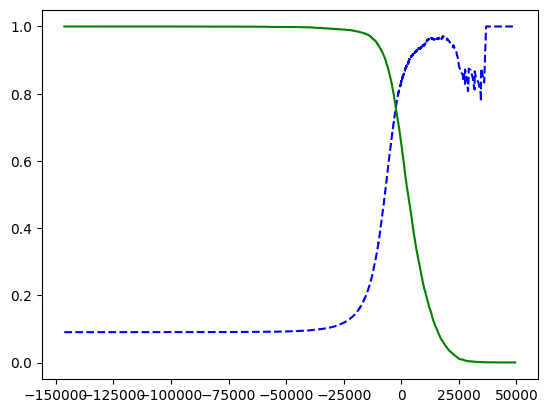

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

- 정밀도: 숫자 하나만큼 이동하면 4/5에서 3/4로 줄어들기 때문에 울퉁불퉁
- 재현율: 임곗값이 하나 올라감에 따라 줄어들 수밖에 없어 부드러운 곡선

좋은 정밀도/재현율 트레이드오프를 선택하는 방법: 재현율에 대한 정밀도 곡선을 그리는 것
- ex) 재현율 80% 근처에서 정밀도가 급격하게 줄어든다면 이 하강점 직전을 트레이드오프로 선택하는 것이 좋음

In [35]:
# np.argmax는 최댓값의 첫 번째 인덱스
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [36]:
# 훈련 세트에 대한 예측 생성
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90) # 정밀도 90%!

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

임곗값을 키우면 정밀도를 높이는 것은 쉬우나 재현율이 너무 낮다면 유용하지 않음

### ROC 곡선

- ROC: 수신기 조작 특성
- 거짓 양성 비율에 대한 진짜 양성 비율
- 1-특이도(진짜 음성 비율)

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

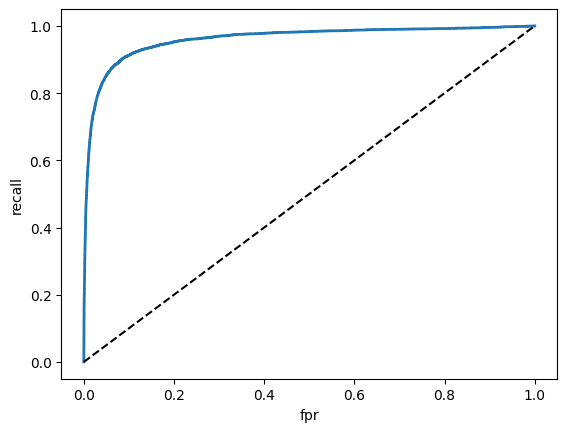

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--') # 대각 점선
  plt.xlabel('fpr')
  plt.ylabel('recall')
  [...]

plot_roc_curve(fpr, tpr)
plt.show()

재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어남
- 점선: 완전한 랜덤 분류기의 ROC 곡선
- 점선에서 멀리 떨어져 있을수록 유리(왼쪽 위 모서리)

In [45]:
# AUC: 곡선 아래의 면적
# 완벽한 분류기: AUC=1
# 완전한 랜덤 분류기: AUC=0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [46]:
# predict_proba: 훈련 세트의 샘플에 대한 점수를 얻어야 함 / 샘플이 행, 클래스가 열, 샘플이 주어진 클래스에 속할 확률을 담은 배열
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [47]:
# 점수 대신에 클래스 확률
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

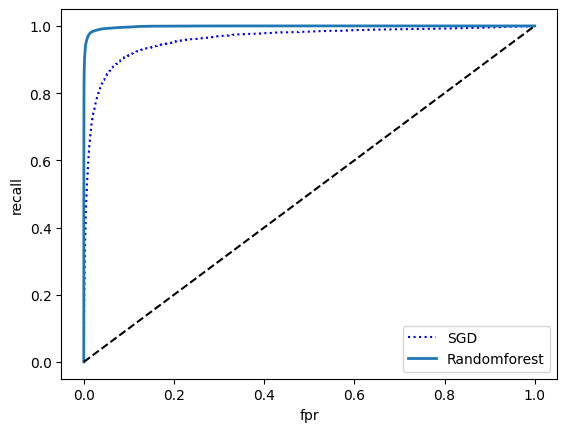

In [50]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Randomforest')
plt.legend(loc='lower right')
plt.show()

랜포가 SGD보다 좋은 것으로 나타남

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류

다중 분류기: 둘 이상의 클래스 구별

- OvR(=OvA)전략: 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
- OvO전략: 0,1구별, 0,2구별, 1,2구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것(ex. 클래스:N, N*(N-1)/2개 분류기 필요)

In [52]:
# 숫자 5 이상을 감지
from sklearn.svm import SVC # 서포트 벡터 머신 분류기
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용합니다.
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [53]:
# decision_function() 메서드를 호출하면 (1개가 아니라) 샘플 당 10개의 점수를 반환
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

가장 높은 점수가 클래스 5에 해당하는 값

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
# classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [56]:
svm_clf.classes_[5]

5

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [59]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

5에서 양수로 예측 결과에 강한 확인을 보이고 있음

In [60]:
# 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [61]:
# 입력 스케일을 조정하면 정확도가 조금 더 올라감
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

In [63]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

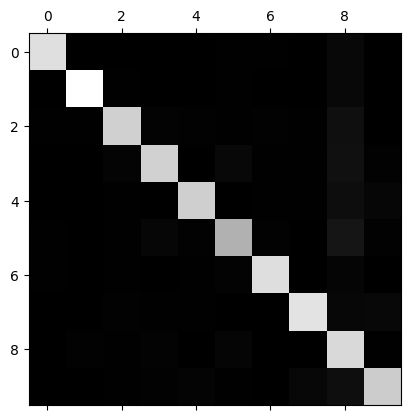

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

숫자 5가 다른 숫자보다 어두워 보이는 이유는 다른 숫자만큼 잘 분류하지 못한다는 것

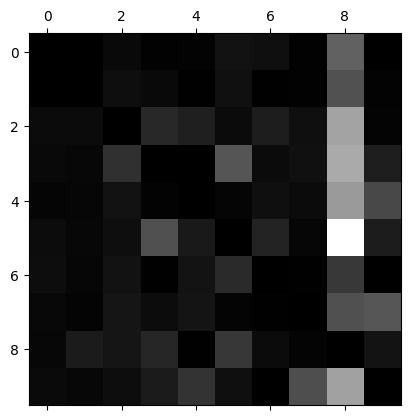

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었다는 것
- 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있음

In [67]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

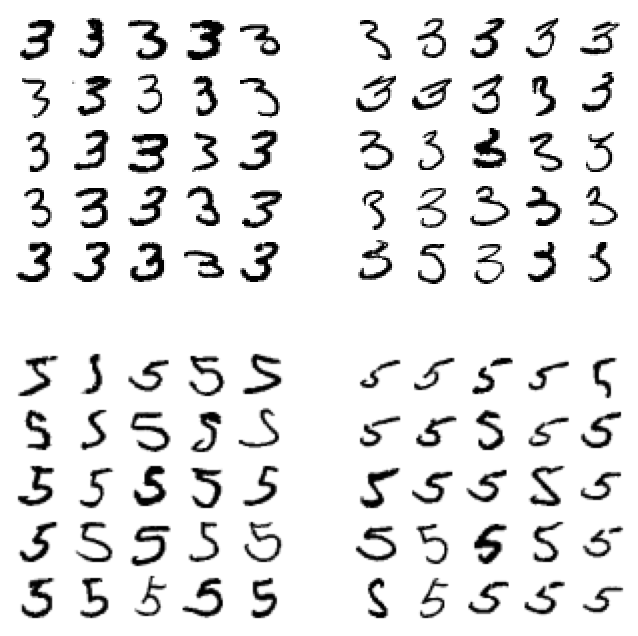

In [68]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a)&(y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b)&(y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b)&(y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중 레이블 분류

- ex. 얼굴 인식 분류기처럼 같은 사진에 여러 사람이 등장하는 경우. 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음
- ex. 분류기가 앨리스와 찰리가 있는 사진을 봄([1,0,1]: ['앨리스ㅇ',밥x','찰리o'])

In [69]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7) # 7,8,9의 큰 값인지
y_train_odd = (y_train % 2 == 1) # 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd] # 각 숫자 이미지에 두 개의 타깃 레이블 담겨있음

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [70]:
knn_clf.predict([some_digit])

array([[False,  True]])

올바르게 분류! 숫자5는 크지않고, 홀수

In [71]:
# 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')
# 지지도를 가중치로 두는 방법: average='weighted'

0.976410265560605

## 3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(=값을 두 개 이상 가질 수 있음)

In [73]:
# MNIST 이용
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise # 잡음 추가
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise # 잡음 추가
y_train_mod = X_train
y_test_mod = X_test

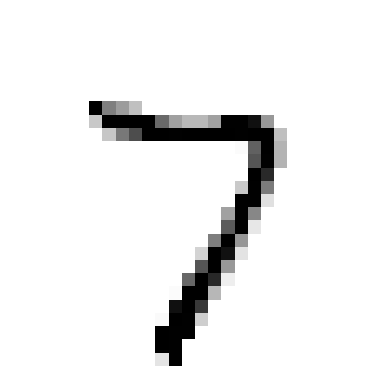

In [76]:
# 분류기를 훈련시켜 이미지를 깨끗하게 만들 것
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)